In [ ]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Mon Aug 16 00:41:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
 Classroom	    Daun		   kulit       Thorax
 coba2		   'face classification'  'My Drive'   yolov3
'Colab Notebooks'   generate_train.py	   STPM


In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import time

In [ ]:
print(os.listdir('/mydrive/Thorax/dataset4'))

['train', 'test']


In [ ]:
IMAGE_WIDTH=250
IMAGE_HEIGHT=250
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
# creating df with train labels
train_filenames = os.listdir('/mydrive/Thorax/dataset4/train')
train_labels = []
for filename in train_filenames:
    label = filename.split('.')[0]
    if label == 'Normal':
        train_labels.append(1)
    else:
        train_labels.append(2)


df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

In [ ]:
df.head()

,id,label
0,Pneumonia.1209.jpg,2
1,Pneumonia.1051.jpg,2
2,Pneumonia.1253.jpg,2
3,Pneumonia.1356.jpg,2
4,Pneumonia.1165.jpg,2


In [ ]:
df.tail()

,id,label
4667,Normal.1433.jpg,1
4668,Normal.1451.jpg,1
4669,Normal.1450.jpg,1
4670,Normal.1443.jpg,1
4671,Normal.1425.jpg,1


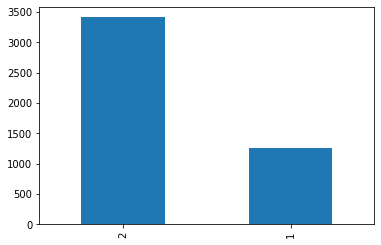

In [ ]:
df['label'].value_counts().plot.bar()

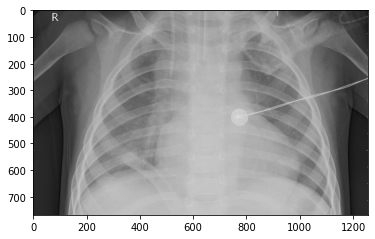

In [ ]:
sample = random.choice(train_filenames)
image = load_img("/mydrive/Thorax/dataset4/train/"+sample)
plt.imshow(image)

In [ ]:
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalAveragePooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from tensorflow.keras.applications  import ResNet50
from keras.models import Model


resnet = ResNet50(input_shape=(244, 244, 3), weights=None, include_top=False)

# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

x = Flatten()(resnet.output)
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

import tensorflow.keras
prediction = tensorflow.keras.layers.Dense(2, activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 90,698,114
Trainable params: 67,110,402
Non-trainable params: 23,587,712
__________________________________________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
earlystop = EarlyStopping(patience=10)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
df["label"] = df["label"].replace({1: 'Normal', 2: 'Pneumonia'})

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

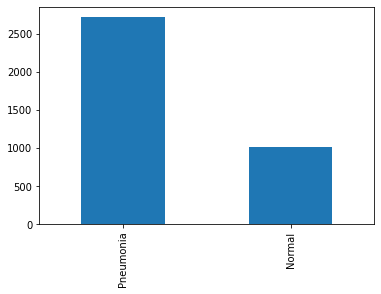

In [ ]:
train_df['label'].value_counts().plot.bar()

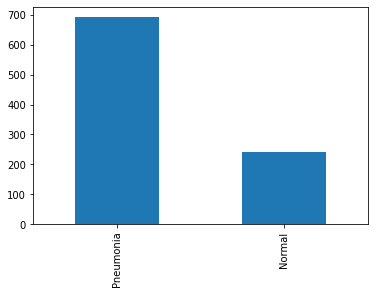

In [ ]:
validate_df['label'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=8

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/mydrive/Thorax/dataset4/train",
    x_col='id',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3737 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/mydrive/Thorax/dataset4/train",
    x_col='id',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 935 validated image filenames belonging to 2 classes.


In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/mydrive/Thorax/dataset4/train",
    x_col='id',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


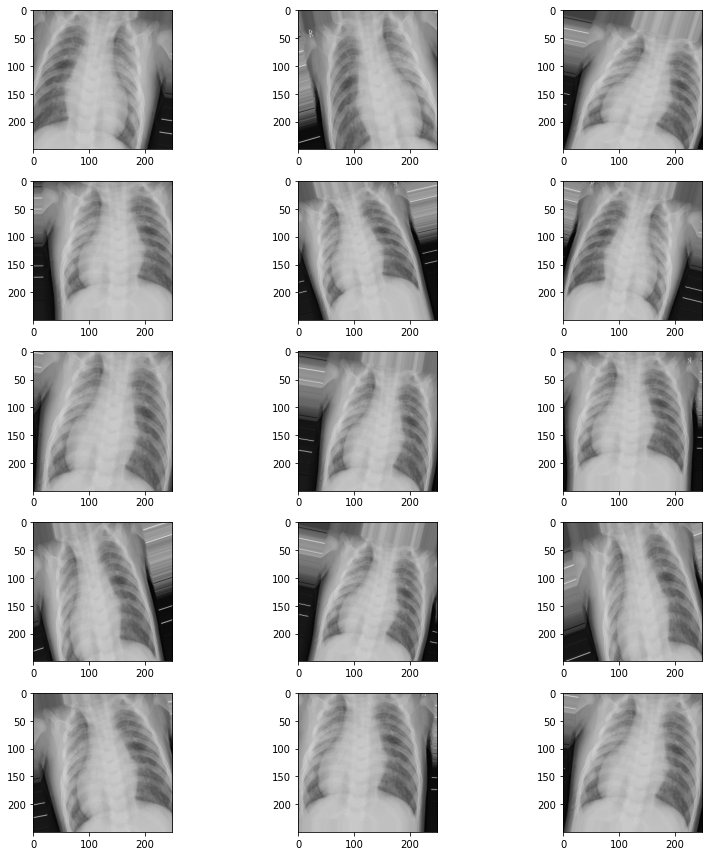

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
t0 = time.time()
epochs=10
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
467/467 [==============================] - 1694s 4s/step - loss: 0.7597 - accuracy: 0.7166 - val_loss: 0.2497 - val_accuracy: 0.9116
Epoch 2/10
467/467 [==============================] - 107s 229ms/step - loss: 0.4151 - accuracy: 0.8342 - val_loss: 0.5464 - val_accuracy: 0.7274
Epoch 3/10
467/467 [==============================] - 106s 226ms/step - loss: 0.3822 - accuracy: 0.8312 - val_loss: 0.4773 - val_accuracy: 0.7769
Epoch 4/10
467/467 [==============================] - 107s 230ms/step - loss: 0.3131 - accuracy: 0.8676 - val_loss: 0.2324 - val_accuracy: 0.9213
Epoch 5/10
467/467 [==============================] - 107s 228ms/step - loss: 0.3331 - accuracy: 0.8547 - val_loss: 0.2184 - val_accuracy: 0.9235
Epoch 6/10
467/467 [==============================] - 107s 228ms/step - loss: 0.2961 - accuracy: 0.8693 - val_loss: 0.2080 - val_accuracy: 0.9192
Epoch 7/10
467/467 [==============================] - 107s 229ms/step - loss: 0.3168 - accuracy: 0.8648 - val_loss: 0.2180 - v

In [ ]:
t1 = time.time()
total = t1-t0
print(total)

2726.840960741043


In [ ]:
model.save_weights("modelAkiecVsBklCNN2.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


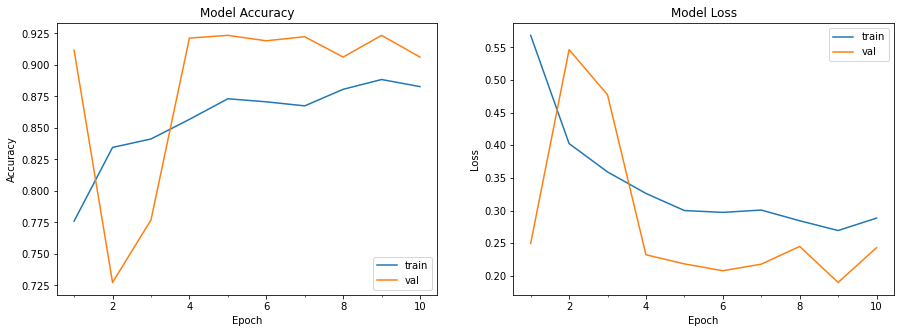

In [ ]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(history)

In [ ]:
test_filenames = os.listdir("/mydrive/Thorax/dataset4/test")
test_df = pd.DataFrame({
    'id': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/mydrive/Thorax/dataset4/test",
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 100 validated image filenames.


In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


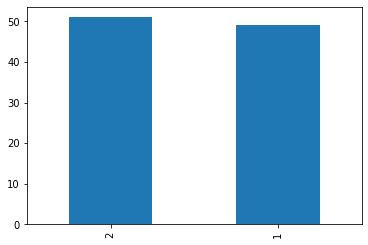

In [ ]:
test_df['label'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['label'] = test_df['label'].replace(label_map)
test_df['label'] = test_df['label'].replace({ 'Pneumonia': 2, 'Normal': 1 })
test_df['label'].value_counts().plot.bar()

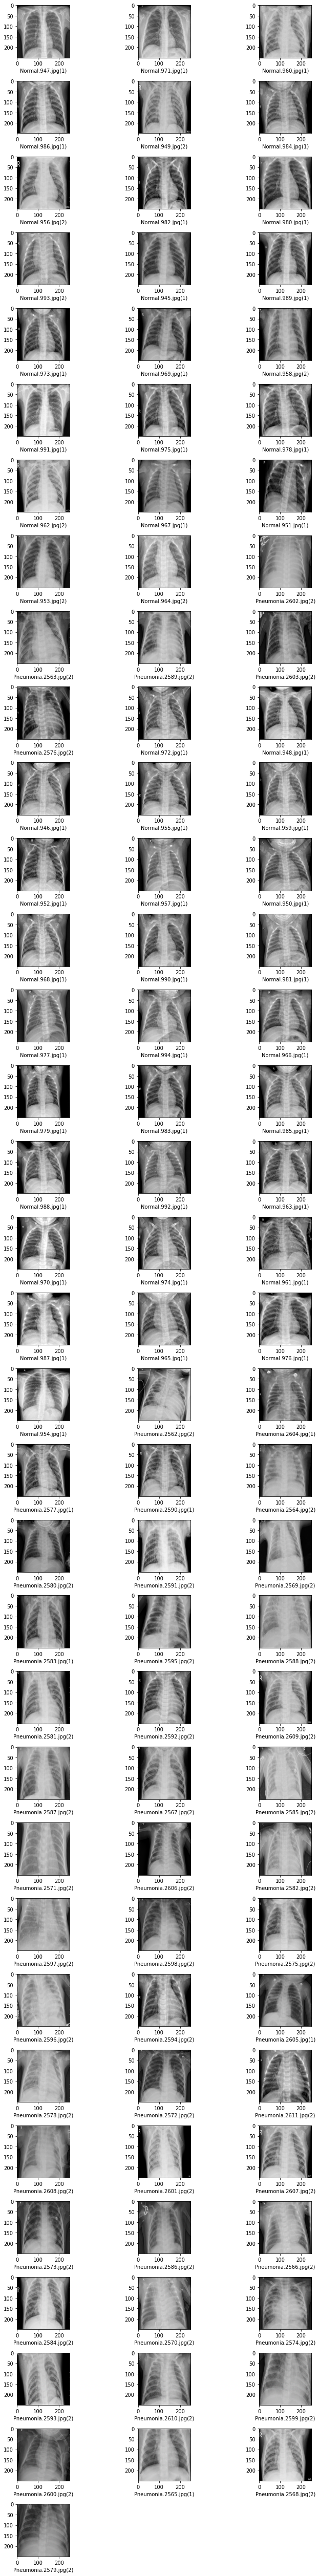

13.295570850372314


In [ ]:
t0 = time.time()
sample_test = test_df.head(101)
sample_test.head()
plt.figure(figsize=(10, 70))
for index, row in sample_test.iterrows():
    filename = row['id']
    category = row['label']
    img = load_img("/mydrive/Thorax/dataset4/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(34, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

t1 = time.time()
total = t1-t0
print(total)